In [1]:
# !pip install --upgrade astropy This fixed shit

# Basic packages
import numpy as np
import time
import sys
import os
from pathlib import Path
import logging
import importlib
# import mysql.connector

import pandas as pd
pd.set_option('display.max_columns', None)

# import warnings
# warnings.filterwarnings("ignore")

# Astropy packages
from astropy.table import Table
from astropy.io import fits

# Matplotlib packages
import matplotlib.pyplot as plt

# Scipy
import scipy
from scipy.optimize import curve_fit
from scipy import signal


import warnings
warnings.filterwarnings('ignore', category=UserWarning, append=True)
warnings.filterwarnings('ignore')


# Useful if working in SSH Vscode
working_directory = '/avatar/yanilach/PhD-Home/binaries_galah-main/spectrum_analysis/BinaryAnalysis'
os.chdir(working_directory)
import AnalysisFunctions as af
from stellarmodel import StellarModel



sys.path.append(os.path.join(working_directory, 'utils'))
import AstroPandas as ap

# Accepts mass, log(age), metallicity. Outputs Teff, logg, and log(L) bolometric (flux)
isochrone_table = Table.read(working_directory +  '/assets/parsec_isochrones_logt_8p00_0p01_10p17_mh_m2p75_0p25_m0p75_mh_m0p60_0p10_0p70_GaiaEDR3_2MASS.fits')
isochrone_interpolator = af.load_isochrones()

# Results from CCF
results_text = pd.read_csv("/avatar/yanilach/PhD-Home/binaries_galah-main/spectrum_analysis" + "/CCF_results.txt", sep='\t', names=["sobject_id", "no_peaks", "RVs"])
results_text['index'] = results_text.index

GALAH_DR4_dir = '/avatar/buder/GALAH_DR4/'
if 'GALAH_DR4' not in locals():
    GALAH_DR4 = ap.FitsToDF(GALAH_DR4_dir + "catalogs/galah_dr4_allspec_240207.fits")
    # GALAH_DR4 = ap.FitsToDF("/avatar/yanilach/PhD-Home/binaries_galah-main/catalogs/galah_dr4_allspec_240207.fits")
    


In [ ]:
# Some obvious binary stars for testing.

if os.path.exists(working_directory + "obvious_binaries.csv"):
    obvious_binaries = pd.read_csv(working_directory + "obvious_binaries.csv")
else:
    obvious_binaries = []
    binary_stars = results_text[results_text['no_peaks'] == 2]
    for sobject_id in binary_stars['sobject_id']:
        dir = GALAH_DR4_dir + 'observations/' + str(sobject_id)[:6] + '/spectra/com/' + str(sobject_id) + '1.fits'
        if os.path.exists(dir):
            obvious_binaries.append(sobject_id)

    df = pd.DataFrame(obvious_binaries)
    df.to_csv(working_directory + "obvious_binaries.csv", index=False)

print(len(obvious_binaries))

3023


170614004601079


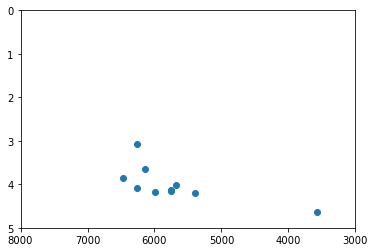

In [3]:


# Get all stars in GALAH DR4 where the sobject_id is in obvious_binaries array
binary_stars = GALAH_DR4[GALAH_DR4['sobject_id'].isin(obvious_binaries['0'].values)]
binary_stars

# Create a random selection of stars, covering the parameter space in teff and logg between 3000 and 8000 K, and 0 and 5 respectively
# This is to test the code with a variety of stars
random_stars = binary_stars.sample(10)
random_stars

plt.figure()
plt.scatter(random_stars['teff'], random_stars['logg'])
plt.xlim(3000, 8000)
plt.ylim(0, 5)
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

print(random_stars['sobject_id'].values[0])

In [4]:
import multiprocessing
import stellarmodel
importlib.reload(stellarmodel)
importlib.reload(af)
from stellarmodel import StellarModel

def normalize_parameters(params, bounds):
    normalized_params = [(p - lb) / (ub - lb) for p, (lb, ub) in zip(params, bounds)]
    return normalized_params

def denormalize_parameters(normalized_params, bounds):
    denormalized_params = [lb + n * (ub - lb) for n, (lb, ub) in zip(normalized_params, bounds)]
    return denormalized_params


# Global variable to store the previous parameter values
previous_params = None

# Define the callback function
def track_step_size(current_params):
    global previous_params
    if previous_params is not None:
        step_size = np.linalg.norm(current_params - previous_params)
        print(f"Step size between iterations: {step_size}")
    previous_params = np.copy(current_params)

def fit_model(sobject_id):
    # sobject_id = 140116004301399
    sobject_data = GALAH_DR4[GALAH_DR4['sobject_id'] == sobject_id]
    if sobject_data.size == 0:
        print('No data for sobject_id in GALAH DR4: ', sobject_id)
        return

    tmass_id = sobject_data['tmass_id'].values[0]

    spectrum = af.read_spectrum(sobject_id, tmass_id)
    if spectrum == False:
        return

    same_fe_h = False

    try:
        single_results = Table.read('/avatar/buder/GALAH_DR4/analysis_products_single/'+str(sobject_id)[:6]+'/'+str(sobject_id)+'/'+str(sobject_id)+'_single_fit_results.fits')
    except:
        print('Single results not available')
        return

    # model = StellarModel(labels = ['teff', 'logg', 'rv', 'fe_h', 'vmic', 'vsini']) # Model with no interpolation
    model = StellarModel(id=sobject_id, labels = ['mass', 'age', 'metallicity', 'rv', 'fe_h', 'vmic', 'vsini'], fixed_labels=['age', 'metallicity'], interpolator=isochrone_interpolator, interpolate_flux=True) # Flux can be used as a free parameter (False) or can be determined from luminosity ratios (from the isochrone) (True)


    model.bounds['f_contr'] = (0, 1)

    # Same bounds for both components. Overwrite with model.bounds['rv_1'] == x if required
    model.set_bounds('teff', (3, 8))
    model.set_bounds('logg', (0.0, 5.0))
    model.set_bounds('fe_h', (-4.0, 1.0))
    model.set_bounds('vmic', (0, 4))
    model.set_bounds('vsini', (0, 30))

    age_min = (10**isochrone_table['logAge'].min()) / 1e9
    age_max = (10**isochrone_table['logAge'].max()) / 1e9

    model.set_bounds('age', (age_min, age_max))
    model.set_bounds('mass', (isochrone_table['mass'].min(), isochrone_table['mass'].max()))
    model.set_bounds('metallicity', (isochrone_table['m_h'].min(), isochrone_table['m_h'].max()))
    model.set_bounds('logL', (isochrone_table['logL'].min(), isochrone_table['logL'].max()))

    model.params['f_contr'] = 0.5


    model.params['rv_1'] = single_results['rv_gauss'][0]
    model.params['rv_2'] = single_results['rv_peak_2'][0]
    if np.isnan(model.params['rv_2']):
        return

    min_rv = min(model.params['rv_1'], model.params['rv_2']) - 100
    max_rv = max(model.params['rv_1'], model.params['rv_2']) + 100
    model.set_bounds('rv', (min_rv, max_rv))

    model.set_param('teff', single_results['teff'][0]/1000.)
    model.set_param('logg', single_results['logg'][0])

    model.set_param('age', sobject_data['age'].values[0].clip(age_min, age_max))
    model.set_param('mass', sobject_data['mass'].values[0])
    model.set_param('metallicity', sobject_data['fe_h'].values[0]) # Approximate m_h as fe_h

    model.set_param('fe_h', single_results['fe_h'][0])
    model.set_param('vmic', 1.5)
    model.set_param('vsini', 4.0)

    print(model.get_params())
    # print(
    #     model.get_params(values_only=False, exclude_fixed=True),
    #       "\n",
    #     model.get_params(values_only=True, exclude_fixed=True),
    #     # model.get_params(values_only=True, exclude_fixed=False)
    # )


fit_model(140116004301399)

{'f_contr': 0.5, 'mass_1': 1.0135012, 'age_1': 6.371642112731934, 'metallicity_1': -0.5258811, 'rv_1': 55.122566, 'fe_h_1': -0.61395806, 'vmic_1': 1.5, 'vsini_1': 4.0, 'mass_2': 1.0135012, 'age_2': 6.371642112731934, 'metallicity_2': -0.5258811, 'rv_2': -52.0, 'fe_h_2': -0.61395806, 'vmic_2': 1.5, 'vsini_2': 4.0, 'teff_1': 6.2633642578125, 'teff_2': 6.2633642578125, 'logg_1': 4.163184, 'logg_2': 4.163184, 'logl_1': 0, 'logl_2': 0}


In [1]:
!pip install pyswarm

Defaulting to user installation because normal site-packages is not writeable
Using legacy 'setup.py install' for pyswarm, since package 'wheel' is not installed.
  distutils: /home/yanilach/.local/lib/python3.9/site-packages
  sysconfig: /home/yanilach/.local/lib64/python3.9/site-packages
  user = True
  home = None
  root = None
  prefix = None
    Running setup.py install for pyswarm ... done


fitting with rvs:  -77.518845 0.0 160524003601098
Initial parameters:
{'f_contr': 0.5, 'mass_1': 1.1497508, 'rv_1': -77.518845, 'vmic_1': 1.5, 'vsini_1': 4.0, 'mass_2': 1.1497508, 'rv_2': 0.0, 'vmic_2': 1.5, 'vsini_2': 4.0, 'FeH': -0.6129891, 'age': 4.454461574554443, 'teff_1': 4.8200184374581, 'teff_2': 4.8200184374581, 'logg_1': 2.3879335098875067, 'logg_2': 2.3879335098875067, 'logl_1': 1.794935358753904, 'logl_2': 1.794935358753904}
Initial bounds:{'f_contr': (0, 1), 'mass_1': (0.09, 5.348), 'rv_1': (-177.5188446044922, 100.0), 'vmic_1': (0, 4), 'vsini_1': (0, 30), 'mass_2': (0.09, 5.348), 'rv_2': (-177.5188446044922, 100.0), 'vmic_2': (0, 4), 'vsini_2': (0, 30), 'FeH': (-4.0, 1.0), 'age': (0.10000921076453691, 14.794149394941304), 'teff_1': (3, 8), 'teff_2': (3, 8), 'logg_1': (0.0, 5.0), 'logg_2': (0.0, 5.0), 'logl_1': (-10000000000.0, 10000000000.0), 'logl_2': (-10000000000.0, 10000000000.0)}



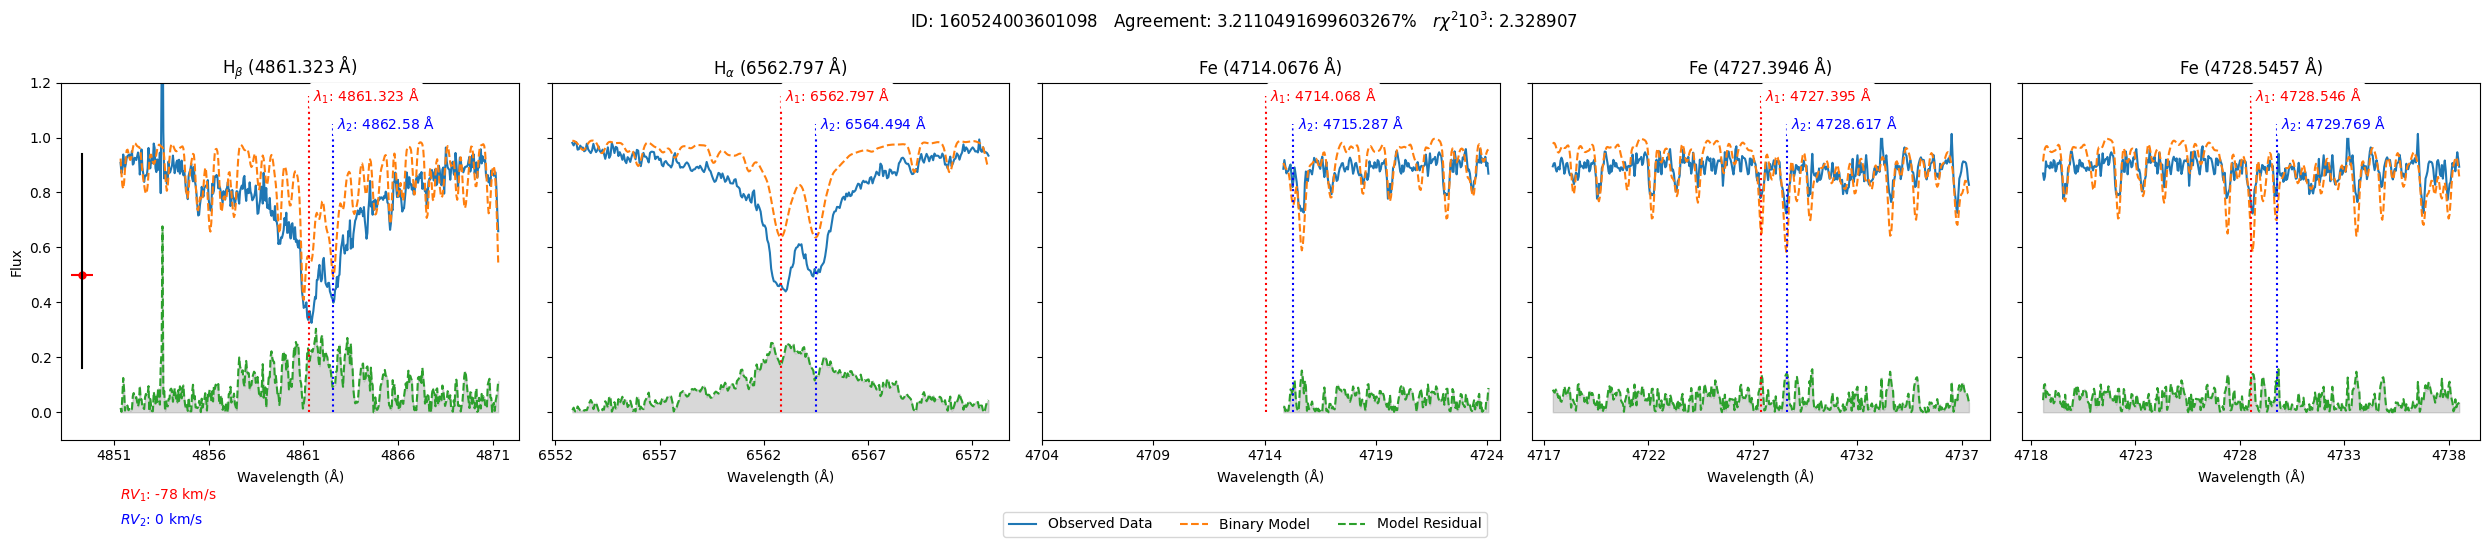

Good curve fit. Updating bounds and initial parameters
Resricted bounds
[(0.4340872473035629, 0.530551080037688), (0.181105349958069, 0.22135098328208433), (0.32430220645536845, 0.3963693634454504), (0.33749240112617634, 0.4124907124875488), (0.12000158472997158, 0.14666860355885414), (0.18113804744508588, 0.2213909468773272), (0.5756972133973278, 0.7036299274856229), (0.33749147114738887, 0.4124895758468087), (0.12000162296924827, 0.14666865029574788), (0.6098929599962815, 0.7454247288843441), (0.26649571954738216, 0.3257169905579115), (0.3447611180415888, 0.42137469982860853), (0.3414581033508661, 0.4173376818732808), (0.4696586716797456, 0.5740272653863557), (0.46297451979096255, 0.5658577464111765), (0.45000000007232277, 0.5500000000883944), (0.45000000007370544, 0.5500000000900844)]
Optimizing with L-BFGS-B
{'f_contr': 0.48231916367062544, 'mass_1': 1.1480577000883632, 'rv_1': -77.5188738954018, 'vmic_1': 1.4999662272274503, 'vsini_1': 4.000052824332386, 'mass_2': 1.14824872607362

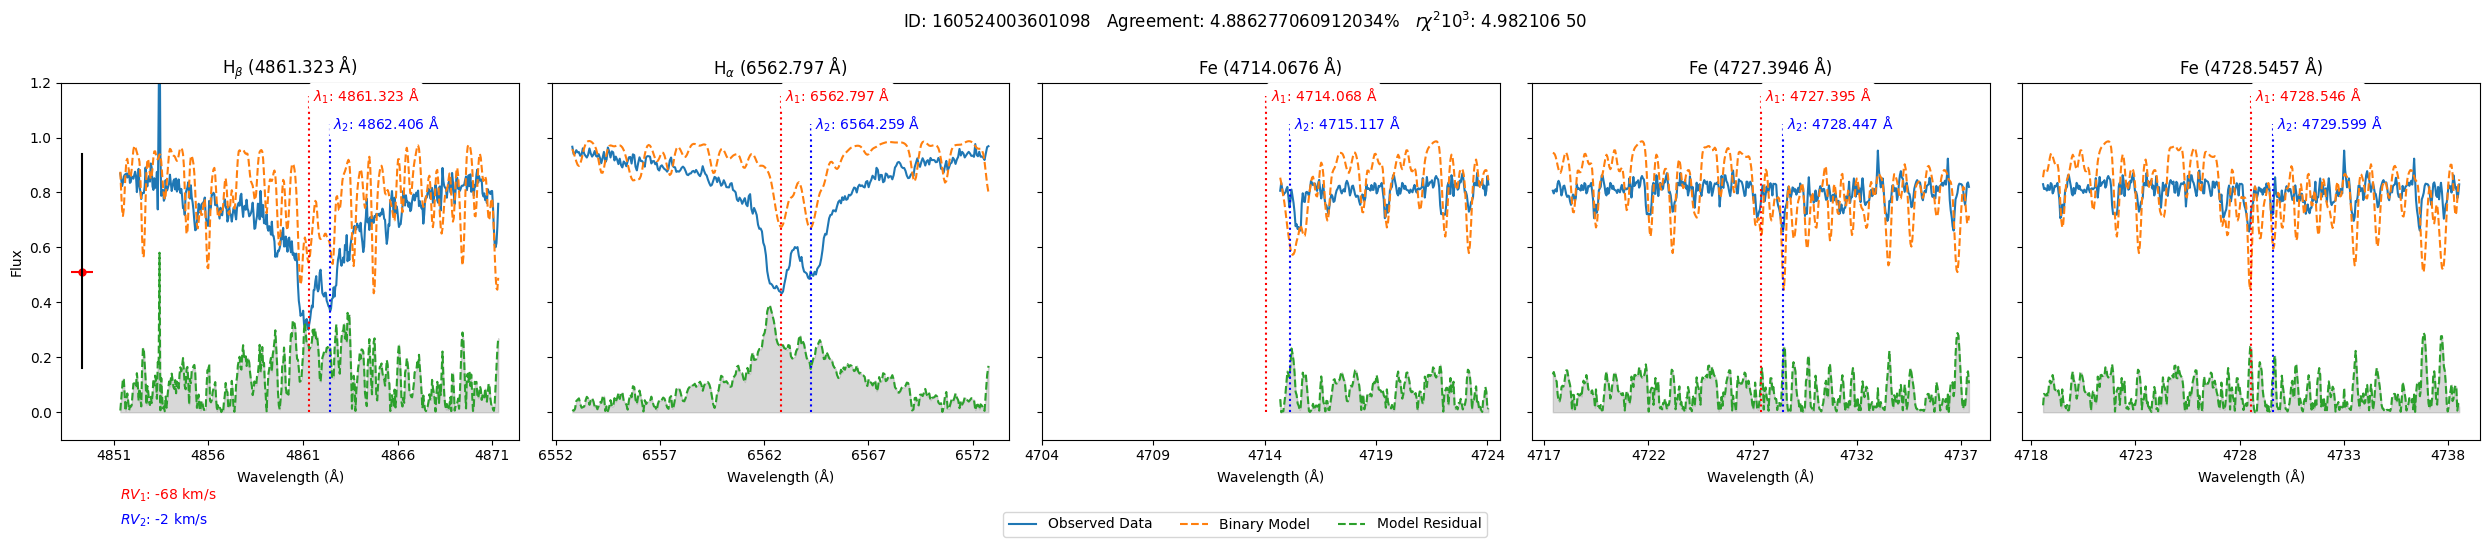

50 {'f_contr': 0.5109627821868646, 'mass_1': 1.223296920151182, 'rv_1': -68.27756492409928, 'vmic_1': 1.4961736330846163, 'vsini_1': 3.8176211173654653, 'mass_2': 1.2058103820347814, 'rv_2': -1.52470758331188, 'vmic_2': 1.414562488290343, 'vsini_2': 4.182504447951618, 'FeH': -0.37238229580152726, 'age': 4.36301034424666, 'teff_1': 4.532843790297314, 'teff_2': 4.539987339388363, 'logg_1': 2.0581227893975433, 'logg_2': 2.076470765090562, 'logl_1': 2.042031787119957, 'logl_2': 2.0229844312741694}


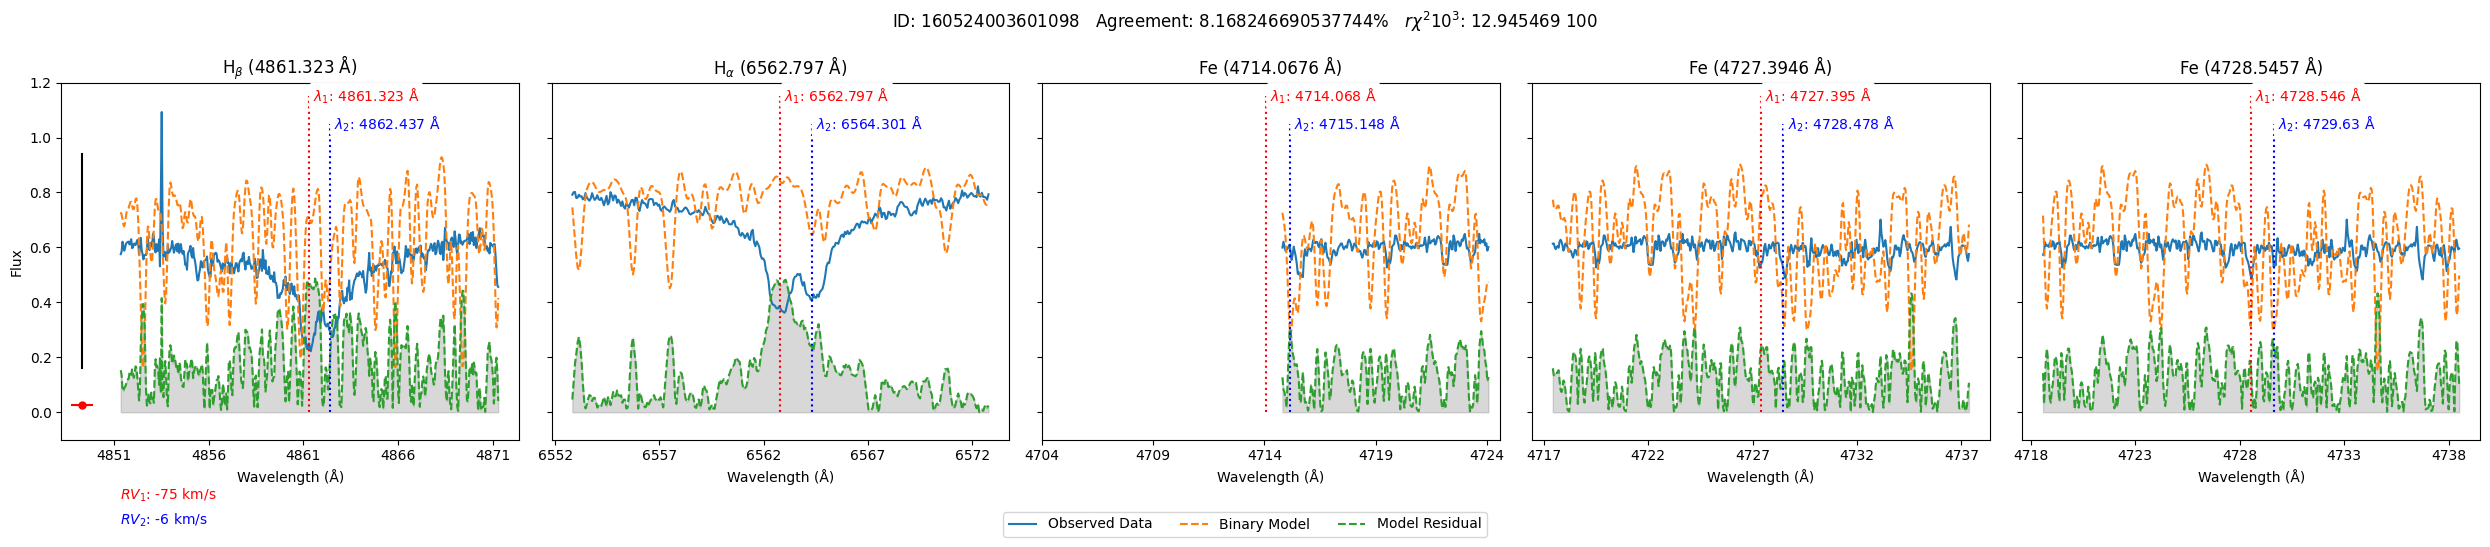

100 {'f_contr': 0.026577372660979905, 'mass_1': 1.1734216262135684, 'rv_1': -75.18531845003955, 'vmic_1': 1.6215240462421487, 'vsini_1': 4.330358997893304, 'mass_2': 1.060556782660111, 'rv_2': -6.486430241411256, 'vmic_2': 1.4282353723349204, 'vsini_2': 4.095505497052418, 'FeH': -0.49723135235108673, 'age': 4.161811284056915, 'teff_1': 4.6469945723740596, 'teff_2': 3.542523743332968, 'logg_1': 2.3282804330672167, 'logg_2': 0.24903708848427933, 'logl_1': 1.7999667774584789, 'logl_2': 3.363756168705629}


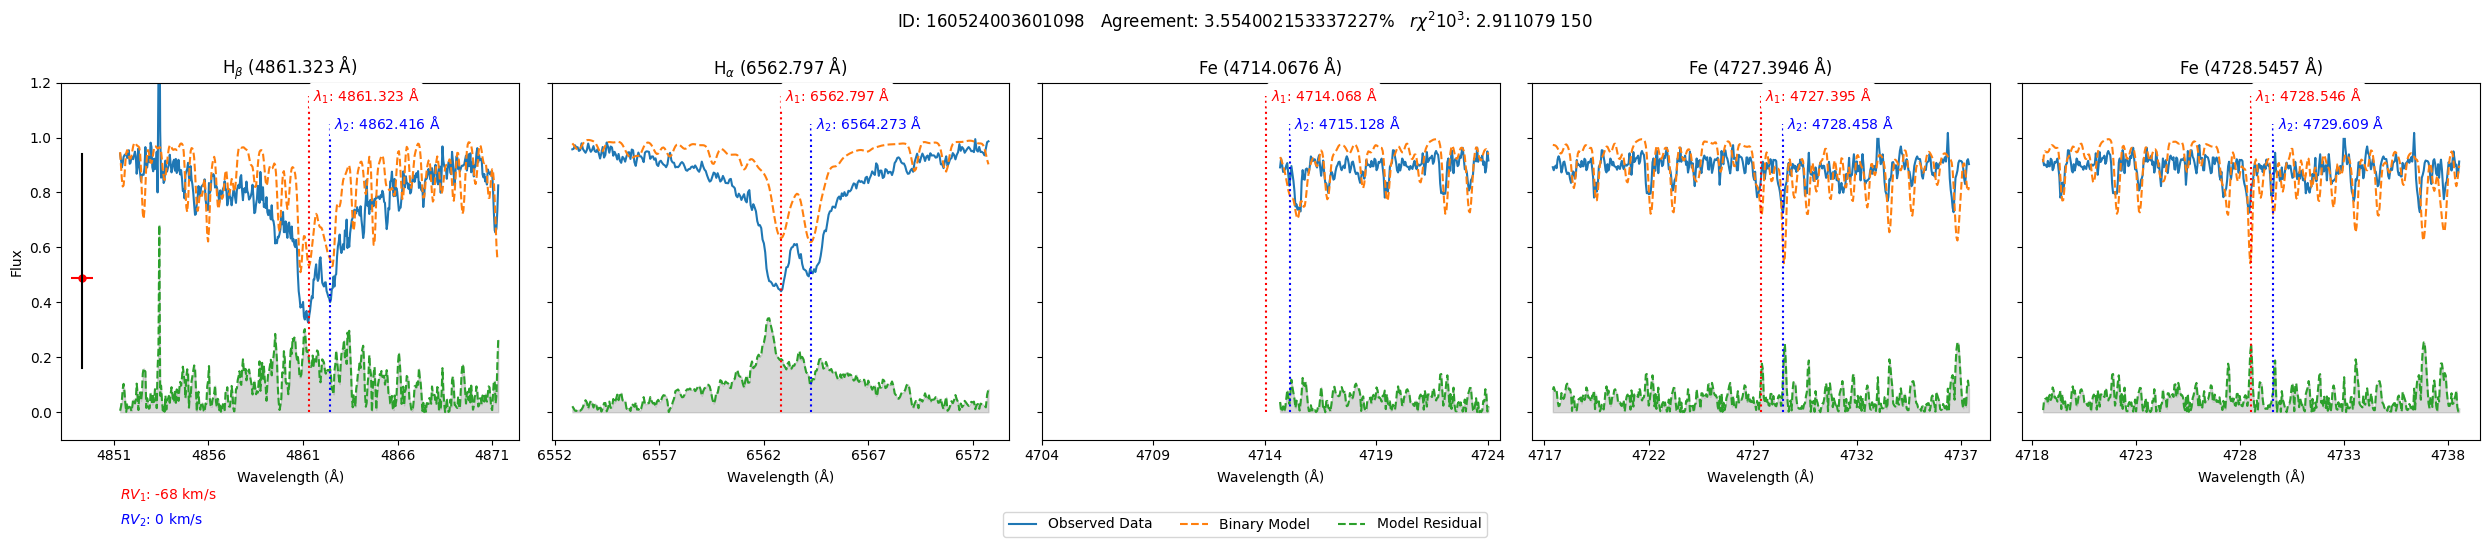

150 {'f_contr': 0.4899297324427093, 'mass_1': 1.1984847836464025, 'rv_1': -67.51887682449276, 'vmic_1': 1.5467171677599962, 'vsini_1': 3.8357678118337075, 'mass_2': 1.2439845113105963, 'rv_2': -0.1140968992010869, 'vmic_2': 1.3871364490689846, 'vsini_2': 3.85822089448913, 'FeH': -0.6687161290432844, 'age': 4.355467430903696, 'teff_1': 4.793276244690849, 'teff_2': 4.789318581077911, 'logg_1': 2.2683201825850783, 'logg_2': 2.256414774011585, 'logl_1': 1.9144649493703585, 'logl_2': 1.931961161879947}


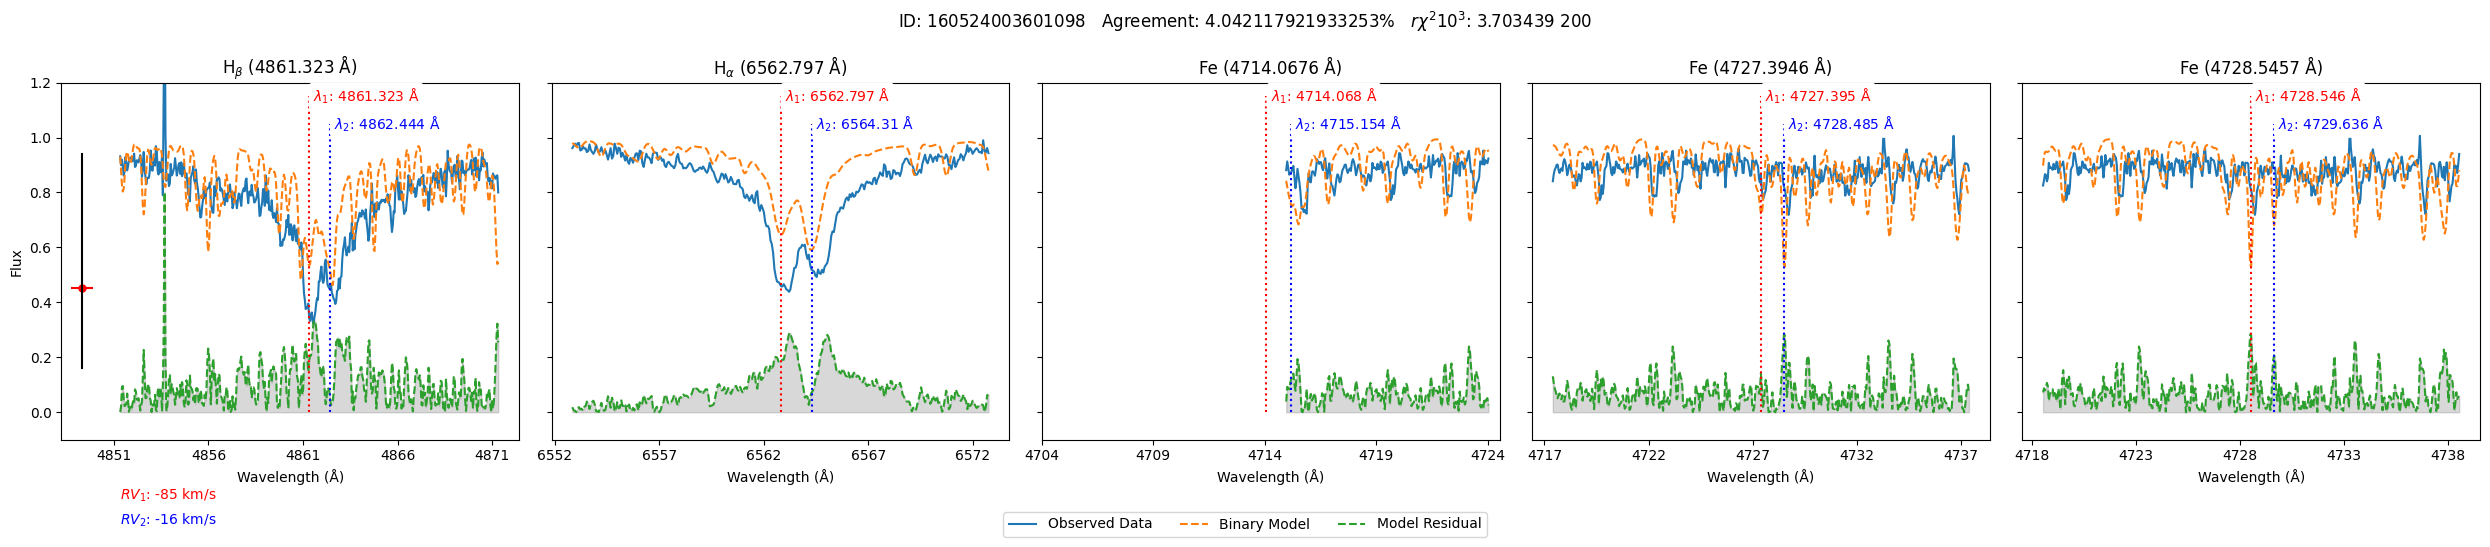

200 {'f_contr': 0.45134995230651503, 'mass_1': 1.1707568927910204, 'rv_1': -84.87422606873807, 'vmic_1': 1.59294542889159, 'vsini_1': 3.944018109652249, 'mass_2': 1.0769973011199185, 'rv_2': -15.771091896463616, 'vmic_2': 1.5223825926136838, 'vsini_2': 3.9521044945444417, 'FeH': -0.45873643858471835, 'age': 4.483433327098768, 'teff_1': 4.8116926980353805, 'teff_2': 5.135765042071545, 'logg_1': 2.5986038730448, 'logg_2': 2.5907182165821303, 'logl_1': 1.588671217535817, 'logl_2': 1.6734532379197498}
Best after iteration 1: [0.48844575 0.20149844 0.34514093 0.36747253 0.13832678 0.1973965
 0.62606999 0.38959783 0.12308588 0.71015091 0.28650658 0.40473532
 0.34166131 0.56416235 0.49236799 0.47565963 0.49853908] 0.0010275173385122965


In [ ]:
import multiprocessing
import stellarmodel
importlib.reload(stellarmodel)
importlib.reload(af)
from stellarmodel import StellarModel
from pyswarm import pso

def normalize_parameters(params, bounds):
    normalized_params = [(p - lb) / (ub - lb) for p, (lb, ub) in zip(params, bounds)]
    return normalized_params

def denormalize_parameters(normalized_params, bounds):
    denormalized_params = [lb + n * (ub - lb) for n, (lb, ub) in zip(normalized_params, bounds)]
    return denormalized_params


# Global variable to store the previous parameter values
previous_params = None

# Define the callback function
def track_step_size(current_params):
    global previous_params
    if previous_params is not None:
        step_size = np.linalg.norm(current_params - previous_params)
        print(f"Step size between iterations: {step_size}")
    previous_params = np.copy(current_params)

def fit_model(sobject_id):
    # sobject_id = 140116004301399
    sobject_data = GALAH_DR4[GALAH_DR4['sobject_id'] == sobject_id]
    if sobject_data.size == 0:
        print('No data for sobject_id in GALAH DR4: ', sobject_id)
        return

    tmass_id = sobject_data['tmass_id'].values[0]

    spectrum = af.read_spectrum(sobject_id, tmass_id)
    if spectrum == False:
        return


    try:
        single_results = Table.read('/avatar/buder/GALAH_DR4/analysis_products_single/'+str(sobject_id)[:6]+'/'+str(sobject_id)+'/'+str(sobject_id)+'_single_fit_results.fits')
    except:
        print('Single results not available')
        return

    # model = StellarModel(labels = ['teff', 'logg', 'rv', 'fe_h', 'vmic', 'vsini']) # Model with no interpolation
    # model = StellarModel(id=sobject_id, labels = ['mass', 'age', 'metallicity', 'rv', 'fe_h', 'vmic', 'vsini'], interpolator=isochrone_interpolator, interpolate_flux=True) # Flux can be used as a free parameter (False) or can be determined from luminosity ratios (from the isochrone) (True)
    
    model = StellarModel(
                id=sobject_id, 
                labels = ['mass', 'rv', 'vmic', 'vsini'], 
                # fixed_labels=['FeH'], # These are parameters that exist, but we don't fit for. They are used as is or are outputs of the interpolation?
                single_labels=['FeH', 'age'], # These are parameters that are the same for both components
                interpolator=isochrone_interpolator, 
                interpolate_flux=True,
                same_fe_h=True
            ) # Flux can be used as a free parameter (False) or can be determined from luminosity ratios (from the isochrone) (True)


    model.bounds['f_contr'] = (0, 1)

    # Same bounds for both components. Overwrite with model.bounds['rv_1'] == x if required
    model.set_bounds('teff', (3, 8))
    model.set_bounds('logg', (0.0, 5.0))
    model.set_bounds('vmic', (0, 4))
    model.set_bounds('vsini', (0, 30))

    age_min = (10**isochrone_table['logAge'].min()) / 1e9
    age_max = (10**isochrone_table['logAge'].max()) / 1e9

    model.set_bounds('FeH', (-4.0, 1.0))
    model.set_bounds('age', (age_min, age_max))
    model.set_bounds('mass', (isochrone_table['mass'].min(), isochrone_table['mass'].max()))
    # model.set_bounds('metallicity', (isochrone_table['m_h'].min(), isochrone_table['m_h'].max()))
    model.set_bounds('logL', (isochrone_table['logL'].min(), isochrone_table['logL'].max()))

    model.params['f_contr'] = 0.5


    model.params['rv_1'] = single_results['rv_gauss'][0]
    model.params['rv_2'] = single_results['rv_peak_2'][0]
    if np.isnan(model.params['rv_2']):
        return

    min_rv = min(model.params['rv_1'], model.params['rv_2']) - 100
    max_rv = max(model.params['rv_1'], model.params['rv_2']) + 100
    model.set_bounds('rv', (min_rv, max_rv))

    model.set_param('teff', single_results['teff'][0]/1000.)
    model.set_param('logg', single_results['logg'][0])

    # Set the parameters required for the interpolation
    model.set_param('mass', sobject_data['mass'].values[0])
    model.set_param('age', sobject_data['age'].values[0].clip(age_min, age_max))

    model.set_param('FeH', single_results['fe_h'][0])
    model.set_param('vmic', 1.5)
    model.set_param('vsini', 4.0)


    # model.add_param('age', sobject_data['age'].values[0].clip(age_min, age_max))
    # model.add_param('metallicity', sobject_data['fe_h'].values[0]) # Approximate m_h as fe_h
    # model.add_param('FeH', sobject_data['fe_h'].values[0]) # Approximate m_h as fe_h

    af.load_neural_network(spectrum)
    af.set_iterations(0)
    af.load_dr3_lines()

    print("fitting with rvs: ", model.params['rv_1'], model.params['rv_2'], sobject_id)



    # Generate an initial model with the starting parameters
    print("Initial parameters:")
    # print(model.params)
    model.interpolate()
    print(model.get_params(values_only=False, exclude_fixed=True))
    # print(model.)
    # print(model.fixed_labels)

    print("Initial bounds:")
    print(model.bounds)


    if len(model.get_params(values_only=True, exclude_fixed=True)) != len(model.bounds):
        print("Length of parameters and bounds do not match")
        # Print out which parameters don't have bounds
        for p in model.get_params(values_only=False, exclude_fixed=True):
            if p not in model.bounds:
                print("Missing: ", p)
        return



    wave_init, data_init, sigma2_init, model_init, unmasked_init = af.return_wave_data_sigma_model(model, spectrum, model.same_fe_h)
    unmasked = unmasked_init

    # Produce a plot with the initial parameters
    model.generate_model(spectrum)
    model.plot()




    def objective_function_norm(normalized_params):

        global previous_params

        # Denormalize the parameters
        model_parameters = denormalize_parameters(normalized_params, model.get_bounds(type='tuple'))

        # Calculate the model flux using the current parameters
        model_flux = af.get_flux_only(wave_init, model, spectrum, model.same_fe_h, unmasked, *model_parameters, plot=True)
        
        # Need to generate a model with the current parameters to determine residual
        model.generate_model(spectrum)
        # residuals = model.get_residual()
        residuals = model.get_rchi2()


        # print('Step ', np.array(normalized_params - previous_params))
        previous_params = np.copy(normalized_params)
        
        return residuals


    # Fit the model to the data. This takes the model parameters and produces a synthetic spectra using the neural network. It then compares this to the observed data and adjusts the model parameters (and thereby the synthetic spectra from the NN) to minimize the difference between the two.
    kwargs={'maxfev':20000,'xtol':1e-5, 'gtol':1e-5, 'ftol':1e-5}
    model_parameters_iter1, covariances_iter1 = curve_fit(
        lambda wave_init, 
            *model_parameters: af.get_flux_only(wave_init, model, spectrum, model.same_fe_h, unmasked, *model_parameters, plot=True),
        wave_init[unmasked_init],
        data_init[unmasked_init],
        p0=model.get_params(values_only=True, exclude_fixed=True),
        sigma=np.sqrt(sigma2_init[unmasked_init]),
        absolute_sigma=True,
        bounds=model.get_bounds(),
        **kwargs
    )



    # Get the original parameter values and bounds
    original_params = model.get_params(values_only=True)# model_parameters_iter1 # model.get_params(values_only=True)
    bounds = model.get_bounds(type='tuple')


    # Normalize the initial parameter values
    normalized_x0 = normalize_parameters(original_params, bounds)
    
    # If the curve fit hasn't failed, assume the parameters returned from it are good. 
    # Use these new values to update the bounds for the minimization and as the initial guess for the next optimization.
    if model.get_residual() < 10:
        print("Good curve fit. Updating bounds and initial parameters")
        # Update bounds to so that they are within 25% of the values returned by curve_fit
        margin = 0.1
        bounds = [(max(lb, p - margin * abs(p)), min(ub, p + margin * abs(p)) ) for p, (lb, ub) in zip(normalized_x0, [(0, 1)] * len(bounds))]
        print("Resricted bounds")
        print(bounds)
        # Ensure these new bounds are also within the (0, 1) bounds
        bounds = [(max(0, lb), min(1, ub)) for lb, ub in bounds]
            
    else:
        bounds = [(0, 1)] * len(bounds)


    

    # print("New bounds:")
    # print(model.get_bounds(type='tuple'))
    # print(bounds)

    # print("Normalized initial parameters:")
    # print(normalized_x0)

    # global previous_params
    # previous_params = normalized_x0

    print("Optimizing with L-BFGS-B")
    print(model.get_params())
    print(normalized_x0)
    print(bounds)

    # result = scipy.optimize.minimize(
    #     objective_function_norm,
    #     x0=normalized_x0, #model.get_params(values_only=True),
    #     method='L-BFGS-B',
    #     bounds= bounds, 
    #     # Ftol is the relative error desired in the sum of squares.
    #     # Gtol is the gradient norm desired in the sum of squares.
    #     # Eps is the step size used for numerical approximation of the jacobian
    #     options={'gtol': 1e-6, 'ftol': 1e-6, 'eps': 1e-5},
    #     callback=track_step_size  # Pass the callback function 
    # )

    # # labels = ['mass', 'rv', 'vmic', 'vsini'], 
    # model.set_bounds('teff', (3, 8))
    # model.set_bounds('mass', (model.params['mass_1'] - (model.params['mass_1'] * 0.05), model.params['mass_1'] + (model.params['mass_1'] * 0.05)))
    # model.set_bounds('rv', (model.params['rv_1'] - 10, model.params['rv_1'] + 10))
    # model.set_bounds('vmic', (model.params['vmic_1'] - 0.5, model.params['vmic_1'] + 0.5))
    # model.set_bounds('vsini', (model.params['vsini_1'] - 2, model.params['vsini_1'] + 2))
    

    # # Perform the optimization again, only fitting Teff
    # result = scipy.optimize.minimize(
    #     objective_function_norm,
    #     x0=normalized_x0, #model.get_params(values_only=True),
    #     method='L-BFGS-B',
    #     bounds= bounds, 
    #     # Ftol is the relative error desired in the sum of squares.
    #     # Gtol is the gradient norm desired in the sum of squares.
    #     options={'maxfun': 10000, 'gtol': 1e-10, 'ftol': 1e-10, 'eps': 1e-5}, #, ,
    #     callback=track_step_size  # Pass the callback function 
    # )


    lower_bounds = [b[0] for b in bounds]
    upper_bounds = [b[1] for b in bounds]

    # Call the pso function
    best_params, best_score = pso(
        objective_function_norm,
        lower_bounds,
        upper_bounds,
        swarmsize=100,        # Number of particles
        maxiter=200,          # Number of iterations
        minstep=1e-8,         # Minimum step size before convergence
        minfunc=1e-8,         # Minimum function change before convergence
        debug=True            # Set to True for detailed logging
    )
    
    # Perform the optimization again, only fitting Teff
    result = scipy.optimize.minimize(
        objective_function_norm,
        x0=model.get_params(values_only=True),
        method='Nelder-Mead',
        # Ftol is the relative error desired in the sum of squares.
        # Gtol is the gradient norm desired in the sum of squares.
        options={'maxfun': 10000, 'fatol': 1e-10, 'xatol': 1e-5, 'disp': True}, #, ,
        callback=track_step_size  # Pass the callback function 
    )
    # print("Final bounds:")
    # print(best_params)
    # print(best_score)


    # # Perform the optimization again, only fitting Teff
    # result = scipy.optimize.minimize(
    #     objective_function_norm,
    #     x0=normalized_x0, #model.get_params(values_only=True),
    #     method='Nelder-Mead',
    #     # Ftol is the relative error desired in the sum of squares.
    #     # Gtol is the gradient norm desired in the sum of squares.
    #     options={'maxfun': 10000, 'fatol': 1e-10, 'xatol': 1e-5, 'disp': True}, #, ,
    #     callback=track_step_size  # Pass the callback function 
    # )

    model.plot()
    print("Final parameters:")
    print(model.params)



    


if locals().get('pool'):
    pool.close()

# Create a pool of worker processes
pool = multiprocessing.Pool(processes=1)

# Iterate over the sobject_ids and apply the fit_model function in parallel
test_ids = [170712002601388 ]
test_ids = [131216002101139] # Sven's Star
test_ids = [131216001101026]
test_ids = [160524003601098]
# results = pool.map(fit_model, random_stars['sobject_id'].values[2:3])
results = pool.map(fit_model, test_ids)

# Close the pool to prevent any more tasks from being submitted
pool.close()

# Wait for all the worker processes to finish
pool.join()


In [7]:
print(results)

[None]


IndexError: list index out of range

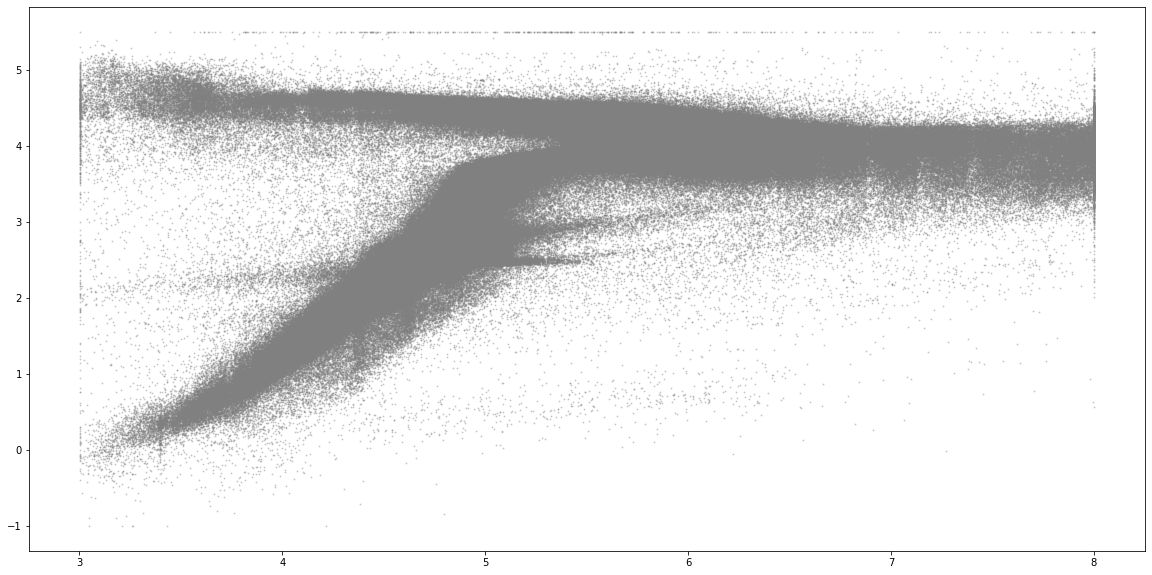

In [14]:
plt.figure(figsize=(20,10))
plt.scatter(GALAH_DR4['teff'].values / 1000, GALAH_DR4['logg'].values, c='gray', s=1, alpha=0.3)
plt.plot(model.param_data['teff_1'], model.param_data['logg_1'], '.', label='Component 1', ls='-', lw=1, c='orange', alpha=0.5)
plt.scatter(model.param_data['teff_1'][-1], model.param_data['logg_1'][-1], label='Component 1', s=350,  c='red', marker='x')
plt.scatter(model.param_data['teff_1'][0], model.param_data['logg_1'][0], label='Component 1', s=350,  c='red', marker='.')

plt.plot(model.param_data['teff_2'], model.param_data['logg_2'], 'o', label='Component 2', ls='-', lw=1)
plt.scatter(model.param_data['teff_2'][-1], model.param_data['logg_2'][-1], label='Component 1', s=350,  c='red', marker='x')
plt.scatter(model.param_data['teff_2'][0], model.param_data['logg_2'][0], label='Component 1', s=350,  c='red', marker='.')

plt.xlabel('teff 1')
plt.ylabel('logg 1' )
plt.ylim(-1, 5)
plt.xlim(3, 8)
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.show()


plt.figure(figsize=(20,10))
x = np.arange(0, len(model.param_data['teff_1']))
plt.plot(x, model.param_data['teff_1'], 'o', label='Component 1 teff', ls='-', lw=1)
plt.plot(x, model.param_data['teff_2'], 'o', label='Component 2 teff', ls='-', lw=1)

plt.plot(x, model.param_data['logg_1'], 'o', label='Component 1 logg', ls='-', lw=1)
plt.plot(x, model.param_data['logg_2'], 'o', label='Component 2 logg', ls='-', lw=1)
plt.legend()

plt.figure(figsize=(20,10))
plt.plot(x, model.param_data['residual'], 'o', label='Component 1', ls='-', lw=1)

plt.figure(figsize=(20,10))
plt.plot(x, model.param_data['f_contr'], 'o', label='Component 1', ls='-', lw=1)



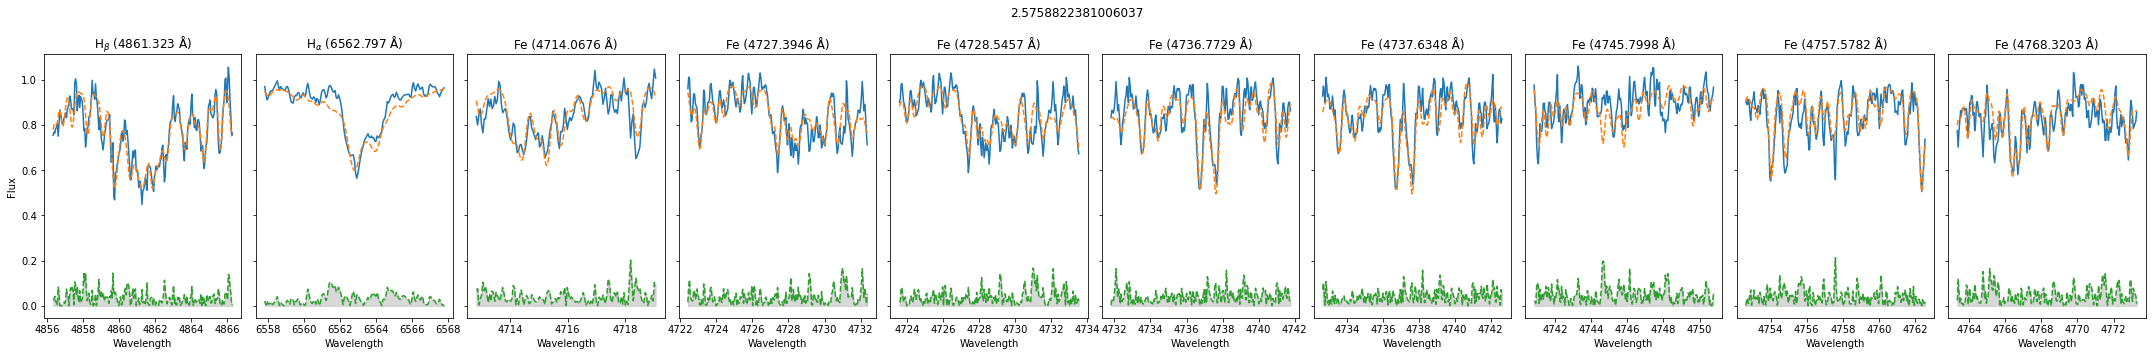

wave,sob,uob,smod,mob
float64,float64,float64,float64,bool
4712.807248783402,0.8377494798193145,0.040011687948020104,0.9081564299831242,True
4712.853270574516,0.8005894656497954,0.03880980391422821,0.8761979950792974,True
4712.899292365629,0.8473295663129368,0.03964869690427325,0.8515193698275472,True
4712.945314156742,0.8717163316620767,0.040645416704673455,0.8422177229572496,True
4712.991335947856,0.8001108438335998,0.039693427510082105,0.8500412280558998,True
4713.037357738969,0.7655396790019225,0.038630954226384726,0.870041972747887,True
4713.083379530082,0.8273962972643376,0.03906836096064783,0.8936049267051984,True
4713.1294013211955,0.8267750159678164,0.03908979228812052,0.9129577568931535,True
4713.1754231123095,0.8724902745062434,0.04017302951466742,0.9249173586648332,True


In [60]:

# Save spectrum
save_spectrum = Table()
save_spectrum['wave'] = wave_iter1
save_spectrum['sob'] = data_iter1
save_spectrum['uob'] = np.sqrt(sigma2_iter1)
save_spectrum['smod'] = model_iter1
save_spectrum['mob'] = unmasked_iter1

save_spectrum